In [ ]:
import numpy as np
import pandas as pd
import re
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import svm

In [ ]:
filename = "covabdab_search_results.csv"
data = pd.read_csv(filename)
with pd.option_context('expand_frame_repr', False):
    print(data.head(20))
print("Data shape: {}".format(data.shape))

         Name Ab or Nb          Binds to Doesn't Bind to Neutralising Vs Not Neutralising Vs Protein + Epitope                            Origin                                          VH or VHH                                                 VL        Heavy V Gene   Heavy J Gene      Light V Gene   Light J Gene                         CDRH3        CDRL3 Structures ABB Homology Model (if no structure)                                            Sources    Date Added  Last Updated Update Description Notes/Following Up?
0    0304-2F8       Ab  SARS-CoV2 (weak)             NaN             NaN           SARS-CoV2            S; Unk  B-cells; SARS-CoV2 Human Patient  EVQLVQSGAEVSQPGESLKISCKGSGYSFTGYWISWVRQMPGKGLE...  EIVMTQSHTLLPVTPGEPASITCRSSQSLLHSNGYNYLDWYLQKPG...    IGHV5-51 (Human)  IGHJ6 (Human)  IGKV2-28 (Human)  IGKJ3 (Human)                ARRGDGLYYYGMDV    MQALQTPQT         ND                     download or view  Xiangyang Chi et al., 2020 (https://science.sc...  Jun 23, 2020  Jun 

In [ ]:
 # Add columns which are not useful like 'Sources' and we want to remove directly in the below list
data2 = data.drop(columns=['Name','CDRH3','CDRL3','Protein + Epitope','Origin','Ab or Nb','Heavy V Gene','Heavy J Gene','Light V Gene','Light J Gene','Sources','Update Description',"Doesn't Bind to","Date Added","Last Updated","Notes/Following Up?","Structures","ABB Homology Model (if no structure)","Not Neutralising Vs"])

colnew = []
for string in data2["Neutralising Vs"]:
  if(string=="SARS-CoV2"):
    colnew.append(1)
  else:
    colnew.append(0)

data2["Neutralising Vs"] = colnew


In [ ]:
with pd.option_context('expand_frame_repr', False):
    print(data2.head(20))

            Binds to  Neutralising Vs                                          VH or VHH                                                 VL
0   SARS-CoV2 (weak)                0  EVQLVQSGAEVSQPGESLKISCKGSGYSFTGYWISWVRQMPGKGLE...  EIVMTQSHTLLPVTPGEPASITCRSSQSLLHSNGYNYLDWYLQKPG...
1          SARS-CoV2                1  EVQLVESGPGLVKPSETLSLTCTASGGSISTYYWSWIRQPPGKGLE...  DIVMTQSPATLSVSPEERATLSCRASQSVSSNLAWYQQKPGQAPRL...
2          SARS-CoV2                0  EVQLVESGGGLVQPGGSLRLSCAASGFTFSTYAMHWVRQAPGKGLE...  EIVLTQSPDSLAVSLGERATINCRSSQSVLYSSNNKNYLAWYQQKP...
3          SARS-CoV2                0  EVQLVESGPGLVKPSETLSLTCAVSGDSTSSSSSYWDWIRQPPGKG...  EIVLTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLAWYQQKP...
4          SARS-CoV2                0  QVQLVQSGGGVVQPGRSLRLSCAAPGFTFSSYGMHWVRQAPGKGLE...  DIVMTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...
5          SARS-CoV2                0  QVQLVQSGSELKKPGASVKVSCKASGYTFTSYAMNWVRQAPGQGLE...  DIVMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQEPGKAPKL...
6   SARS-CoV2 (weak)

In [ ]:
list_without_weak = []

for row in data2.itertuples(index = False):
  if(row[0]=="SARS-CoV2"):
      list_without_weak.append(row)

list_without_weak = np.array(list_without_weak)
df = pd.DataFrame(list_without_weak, columns = ['binds', 'neutralizing', 'seq1', 'seq2'])

df =  df.drop(columns=["binds"])
df = df[df["seq1"]!="ND"]
df =  df[df["seq2"]!="ND"]
train = df

train

,neutralizing,seq1,seq2
0,1,EVQLVESGPGLVKPSETLSLTCTASGGSISTYYWSWIRQPPGKGLE...,DIVMTQSPATLSVSPEERATLSCRASQSVSSNLAWYQQKPGQAPRL...
1,0,EVQLVESGGGLVQPGGSLRLSCAASGFTFSTYAMHWVRQAPGKGLE...,EIVLTQSPDSLAVSLGERATINCRSSQSVLYSSNNKNYLAWYQQKP...
2,0,EVQLVESGPGLVKPSETLSLTCAVSGDSTSSSSSYWDWIRQPPGKG...,EIVLTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLAWYQQKP...
3,0,QVQLVQSGGGVVQPGRSLRLSCAAPGFTFSSYGMHWVRQAPGKGLE...,DIVMTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...
4,0,QVQLVQSGSELKKPGASVKVSCKASGYTFTSYAMNWVRQAPGQGLE...,DIVMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQEPGKAPKL...
...,...,...,...
1165,1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLE...,QSVLTQPASVSGSPGQSITISCTGTSSDVGSYNLVSWYQQHPGKAP...
1167,0,QVQLVQSGAEVKKPGASVKVSCKASGYTFTNYFIHWVRQAPGQGLE...,QSVLTQPPSASGTPGQRVTISCSGSTSNIGSNAVNWYQQLPGTAPK...
1168,1,EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMNWVRQAPGKGLE...,SYELTQPPSVSVSPGQTARITCSGDALPRHYSYWYQQKPGQAPVLL...
1171,1,EVQLVESGGGLVQPGGSLRLSCAASGFTVRSNYMSWVRQAPGKGLE...,DIQLTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...


In [ ]:
# Generating PFeatures
# List of 21 amino acids
aminoAcids = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','X']

# Dipeptide array generation
di_peptide_array = []
for i in range(len(aminoAcids)):
  for j in range(len(aminoAcids)):
    di_peptide_array.append(aminoAcids[i]+""+aminoAcids[j])


# Computing aminoacids composition features
# train = data
for aminoAcid in aminoAcids:
  list_column = []
  for sequence in train['seq1']:
    num = sequence.count(aminoAcid)
    den = len(sequence)
    temp = num/den
    list_column.append(temp)
  train[aminoAcid+"a1"]=list_column


for aminoAcid in aminoAcids:
  list_column = []
  for sequence in train['seq2']:
    num = sequence.count(aminoAcid)
    den = len(sequence)
    temp = num/den
    list_column.append(temp)
  train[aminoAcid+"a2"]=list_column




print(di_peptide_array)
print(train)

['AA', 'AR', 'AN', 'AD', 'AC', 'AQ', 'AE', 'AG', 'AH', 'AI', 'AL', 'AK', 'AM', 'AF', 'AP', 'AS', 'AT', 'AW', 'AY', 'AV', 'AX', 'RA', 'RR', 'RN', 'RD', 'RC', 'RQ', 'RE', 'RG', 'RH', 'RI', 'RL', 'RK', 'RM', 'RF', 'RP', 'RS', 'RT', 'RW', 'RY', 'RV', 'RX', 'NA', 'NR', 'NN', 'ND', 'NC', 'NQ', 'NE', 'NG', 'NH', 'NI', 'NL', 'NK', 'NM', 'NF', 'NP', 'NS', 'NT', 'NW', 'NY', 'NV', 'NX', 'DA', 'DR', 'DN', 'DD', 'DC', 'DQ', 'DE', 'DG', 'DH', 'DI', 'DL', 'DK', 'DM', 'DF', 'DP', 'DS', 'DT', 'DW', 'DY', 'DV', 'DX', 'CA', 'CR', 'CN', 'CD', 'CC', 'CQ', 'CE', 'CG', 'CH', 'CI', 'CL', 'CK', 'CM', 'CF', 'CP', 'CS', 'CT', 'CW', 'CY', 'CV', 'CX', 'QA', 'QR', 'QN', 'QD', 'QC', 'QQ', 'QE', 'QG', 'QH', 'QI', 'QL', 'QK', 'QM', 'QF', 'QP', 'QS', 'QT', 'QW', 'QY', 'QV', 'QX', 'EA', 'ER', 'EN', 'ED', 'EC', 'EQ', 'EE', 'EG', 'EH', 'EI', 'EL', 'EK', 'EM', 'EF', 'EP', 'ES', 'ET', 'EW', 'EY', 'EV', 'EX', 'GA', 'GR', 'GN', 'GD', 'GC', 'GQ', 'GE', 'GG', 'GH', 'GI', 'GL', 'GK', 'GM', 'GF', 'GP', 'GS', 'GT', 'GW', 'GY', 'GV

In [ ]:
# Main 1st order dipeptide Feature Generation
for dp in di_peptide_array:
  di_gap = []
  for sequence in train['seq1']:
    pattern = dp[0]+'[A-Z]'+dp[1]
    if (len(sequence)-1>0):
      di_gap.append(len(re.findall(pattern,sequence))/(len(sequence)-1))
    else:
      di_gap.append(0)
  train[dp+'_z1']=di_gap


for dp in di_peptide_array:
  di_gap = []
  for sequence in train['seq2']:
    pattern = dp[0]+'[A-Z]'+dp[1]
    if (len(sequence)-1>0):
      di_gap.append(len(re.findall(pattern,sequence))/(len(sequence)-1))
    else:
      di_gap.append(0)
  train[dp+'_z2']=di_gap

train =  train.drop(columns=["seq1","seq2"])

print(train)

     neutralizing       Aa1       Ra1       Na1  ...  XW_z2  XY_z2  XV_z2  XX_z2
0               1  0.048387  0.040323  0.024194  ...    0.0    0.0    0.0    0.0
1               0  0.068376  0.059829  0.034188  ...    0.0    0.0    0.0    0.0
2               0  0.056452  0.024194  0.016129  ...    0.0    0.0    0.0    0.0
3               0  0.062016  0.046512  0.031008  ...    0.0    0.0    0.0    0.0
4               0  0.074074  0.029630  0.029630  ...    0.0    0.0    0.0    0.0
...           ...       ...       ...       ...  ...    ...    ...    ...    ...
1165            1  0.071429  0.039683  0.023810  ...    0.0    0.0    0.0    0.0
1167            0  0.065041  0.048780  0.024390  ...    0.0    0.0    0.0    0.0
1168            1  0.072581  0.048387  0.032258  ...    0.0    0.0    0.0    0.0
1171            1  0.068376  0.059829  0.034188  ...    0.0    0.0    0.0    0.0
1172            1  0.073171  0.040650  0.032520  ...    0.0    0.0    0.0    0.0

[1087 rows x 925 columns]


In [ ]:
Y = train['neutralizing']
X = train.drop(columns=['neutralizing'])

print(X)
print(Y)

           Aa1       Ra1       Na1       Da1  ...  XW_z2  XY_z2  XV_z2  XX_z2
0     0.048387  0.040323  0.024194  0.032258  ...    0.0    0.0    0.0    0.0
1     0.068376  0.059829  0.034188  0.025641  ...    0.0    0.0    0.0    0.0
2     0.056452  0.024194  0.016129  0.048387  ...    0.0    0.0    0.0    0.0
3     0.062016  0.046512  0.031008  0.046512  ...    0.0    0.0    0.0    0.0
4     0.074074  0.029630  0.029630  0.029630  ...    0.0    0.0    0.0    0.0
...        ...       ...       ...       ...  ...    ...    ...    ...    ...
1165  0.071429  0.039683  0.023810  0.039683  ...    0.0    0.0    0.0    0.0
1167  0.065041  0.048780  0.024390  0.024390  ...    0.0    0.0    0.0    0.0
1168  0.072581  0.048387  0.032258  0.056452  ...    0.0    0.0    0.0    0.0
1171  0.068376  0.059829  0.034188  0.042735  ...    0.0    0.0    0.0    0.0
1172  0.073171  0.040650  0.032520  0.040650  ...    0.0    0.0    0.0    0.0

[1087 rows x 924 columns]
0       1
1       0
2       0
3      

In [ ]:
# OVERSAMPLING
oversample = RandomOverSampler(sampling_strategy='minority')
X, Y = oversample.fit_resample(X,Y)

print(X.shape)
print(Y.shape)

(1502, 924)
(1502,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Applying Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0,n_estimators=1000)
clf.fit(X, Y)
print(clf.score(X,Y))

0.9946737683089214


In [ ]:
clf = svm.SVC(kernel='rbf', C=50, random_state=42)
scores = cross_val_score(clf, X, Y, cv=4)
print(scores)

[0.80585106 0.78723404 0.79733333 0.81333333]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


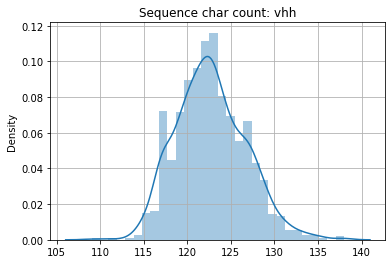

In [ ]:
def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

df['seq_char_count']= df['seq1'].apply(lambda x: len(x))

plot_seq_count(df,"vhh")


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


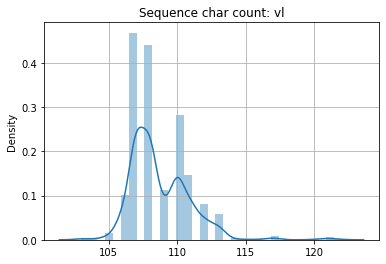

In [ ]:
df['seq_char_count']= df['seq2'].apply(lambda x: len(x))
plot_seq_count(df,"vl")